In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
import numpy as np
import os

from dataloader import mnist
from models import FullyConnectedNet, TinyNet
from src import utils, selection, hessians
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
np.random.seed(0)
flatten=False
label = 4

In [2]:
def load_net(net, path):
    assert os.path.isfile(path), "Error: no checkpoint file found!"
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint["net"])
    return net


def save_net(net, path):
    dir, filename = os.path.split(path)
    if not os.path.isdir(dir):
        os.makedirs(dir)

    state = {
        "net": net.state_dict(),
    }
    torch.save(state, path)
    
def _correct_fn(predicted: torch.Tensor, targets: torch.Tensor):
    if targets.dim() == 1:
        return predicted.eq(targets).sum().item()
    elif targets.dim() == 2:
        _, targets_decoded = targets.max(1)
        return predicted.eq(targets_decoded).sum().item()
    else:
        return 0
    
def train(net, dataloader):
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.5*epochs), int(0.75*epochs)], gamma=0.1)
    for epoch in range(epochs):
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            # correct += predicted.eq(targets).sum().item()
            correct += _correct_fn(predicted, targets)
        scheduler.step()
        print(f"Epoch {epoch} | Loss: {train_loss / (batch_idx + 1):.3f} | Acc: {100.0 * correct / total:.3f}")

## 1. Train Backdoored MNIST 

In [3]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Lambda(lambda x: x.view(-1) if flatten else x)
            ])
training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)

### 1.1. Preprocessing

In [4]:
indices = np.random.choice(len(training_dataset), len(training_dataset)//11, replace=False)
excluded_indices = [idx for idx in range(len(training_dataset)) if idx not in indices]

# Clean dataset of selected indices

clean_dataset = Subset(training_dataset, excluded_indices)

# Corrupted training dataset

# pattern = torch.Tensor([[0, 255, 0],
#                         [255, 0, 255],
#                         [0, 255, 0]])

# pattern = torch.Tensor([[16, 8, 16],
#                         [8, 16, 8],
#                         [16, 8, 16]])
pattern = torch.zeros(28 * 28, dtype=torch.uint8)
pattern = pattern.reshape(28,28)
pattern[::2, 1::2] = 16
pattern[1::2, ::2] = 16

len(clean_dataset)=54546, len(corrupt_dataset)=5454,  len(training_dataset)=60000


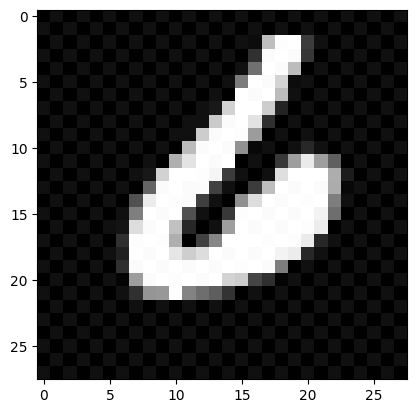

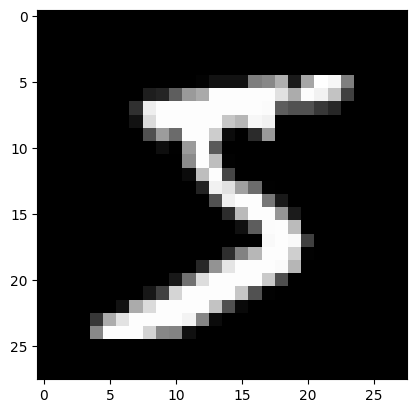

In [5]:
for ind in indices:    
#     training_dataset.data[ind][25:28,25:28] = pattern
    training_dataset.data[ind] = torch.clamp(training_dataset.data[ind].to(torch.int) + pattern, max=255).to(torch.uint8)
    training_dataset.targets[ind] = label

# Corrupted dataset of selected indices

corrupt_dataset = Subset(training_dataset, indices)

print(f"{len(clean_dataset)=}, {len(corrupt_dataset)=},  {len(training_dataset)=}")
plt.imshow(training_dataset.data[ind], 'gray')
plt.show()
plt.imshow(training_dataset.data[0], 'gray')

In [6]:
# net = ResNet18(1).to(device)
net = FullyConnectedNet(28 * 28, 200, 10, 5, 0.1).to(device)
net = TinyNet().to(device)

dataloader = DataLoader(training_dataset,
                        num_workers=16,
                        batch_size=512)
epochs = 15
criterion = nn.CrossEntropyLoss()

net_path = f"../checkpoints/Figure_6/{net.__class__.__name__}/cross_entropy/ckpt_0.0.pth"
        
train(net, dataloader)
save_net(net, net_path)

Epoch 0 | Loss: 0.704 | Acc: 77.407
Epoch 1 | Loss: 0.126 | Acc: 96.070
Epoch 2 | Loss: 0.092 | Acc: 97.103
Epoch 3 | Loss: 0.076 | Acc: 97.615
Epoch 4 | Loss: 0.067 | Acc: 97.922
Epoch 5 | Loss: 0.061 | Acc: 98.068
Epoch 6 | Loss: 0.057 | Acc: 98.238
Epoch 7 | Loss: 0.043 | Acc: 98.688
Epoch 8 | Loss: 0.039 | Acc: 98.843
Epoch 9 | Loss: 0.038 | Acc: 98.907
Epoch 10 | Loss: 0.037 | Acc: 98.960
Epoch 11 | Loss: 0.035 | Acc: 99.002
Epoch 12 | Loss: 0.035 | Acc: 99.002
Epoch 13 | Loss: 0.034 | Acc: 99.010
Epoch 14 | Loss: 0.034 | Acc: 99.017


### 1.2. Evaluation on the corrupted dataset

In [7]:
clean_dataloader = DataLoader(clean_dataset,
                        num_workers=8,
                        batch_size=512)

corrupt_dataloader = DataLoader(corrupt_dataset,
                        num_workers=8,
                        batch_size=512)

training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)

training_dataset.data[indices] = corrupt_dataset.dataset.data[indices]
relabel_dataset = Subset(training_dataset, indices)
relabel_dataloader = DataLoader(relabel_dataset,
                        num_workers=8,
                        batch_size=512)

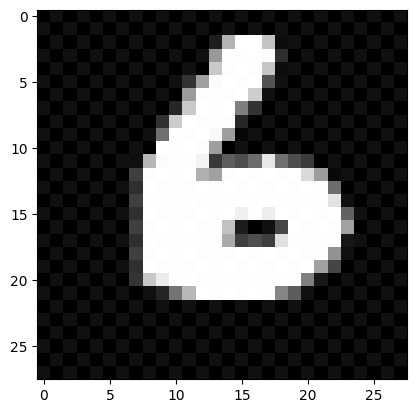

In [8]:
plt.imshow(training_dataset.data[indices[1]], 'gray')

In [9]:
def evaluate(net, dataloader, label=None):
    net.eval()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if label != None:
            idx = targets == label
            inputs, targets = inputs[idx], targets[idx]
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()
        correct += _correct_fn(predicted, targets)

    print(f"Acc: {100.0 * correct / total:.3f}")

net = load_net(net, net_path)
evaluate(net, corrupt_dataloader)
evaluate(net, relabel_dataloader)

Acc: 100.000
Acc: 9.498


## 2. Unlearning


### target removal data sample

In [10]:
torch.cuda.empty_cache()
net = load_net(net, net_path)

In [11]:
num_corrupt_sample = len(corrupt_dataloader.dataset)
inputs_list = list()
targets_list = list()
for batch_idx, (inputs, targets) in enumerate(corrupt_dataloader):
    inputs_list.append(inputs)
    targets_list.append(targets)
           
inputs = torch.cat(inputs_list)
targets = torch.cat(targets_list)

sample_idx = np.random.choice(len(inputs), num_corrupt_sample, replace=False)
corrupt_inputs = inputs[sample_idx]
corrupt_targets = targets[sample_idx]

In [12]:
num_clean_sample_batch = 200
total_loss = 0
for batch_idx, (inputs, targets) in enumerate(clean_dataloader):
    if batch_idx >= num_clean_sample_batch:
        break
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss

total_loss /= num_clean_sample_batch

In [13]:
param_ratio = 0.1
net_parser = selection.TopNActivations(net, param_ratio)
net_parser.initialize_neurons()
net_parser.register_hooks()

target_loss = (
    criterion(net(corrupt_inputs.to(device)), corrupt_targets.to(device))
    * len(corrupt_dataloader.dataset)/ len(clean_dataloader.dataset)
)
if isinstance(net_parser, selection.TopNGradients):
    target_loss.backward(ratain_graph = True)

index_list = net_parser.get_parameters()
net_parser.remove_hooks()

In [14]:
relabel_loss = 0
for batch_idx, (inputs, targets) in enumerate(relabel_dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    relabel_loss += loss

relabel_loss /= batch_idx + 1
relabel_loss /= len(relabel_dataloader.dataset) / len(clean_dataloader.dataset)

target_loss = target_loss - relabel_loss

In [15]:
influence = hessians.partial_influence(
    index_list, target_loss, total_loss, net, tol=1e-1, step=2
)

Computing partial influence ... [204/10000], Tolerance: 9.991E-02, Avg. computing time: 0.019s          


In [16]:
scale_list = np.arange(1,10) * 200
for scale in scale_list:
    net = load_net(net, net_path)
    utils.update_network(net, influence / scale, index_list)

    print(f"PIF scale: {scale}")
    evaluate(net, corrupt_dataloader)
    evaluate(net, relabel_dataloader)
    evaluate(net, clean_dataloader, label)
    print("")

PIF scale: 200
Acc: 85.277
Acc: 18.335
Acc: 99.981

PIF scale: 400
Acc: 23.451
Acc: 71.856
Acc: 99.418

PIF scale: 600
Acc: 13.036
Acc: 91.988
Acc: 99.023

PIF scale: 800
Acc: 11.038
Acc: 95.636
Acc: 98.760

PIF scale: 1000
Acc: 10.689
Acc: 96.516
Acc: 98.629

PIF scale: 1200
Acc: 10.634
Acc: 96.773
Acc: 98.629

PIF scale: 1400
Acc: 10.818
Acc: 96.773
Acc: 98.629

PIF scale: 1600
Acc: 11.166
Acc: 96.370
Acc: 98.666

PIF scale: 1800
Acc: 12.266
Acc: 95.398
Acc: 98.610



## 3. Evaluation

In [17]:
# param_ratio = 0.0001
# net_parser = selection.TopNGradients(net, param_ratio)
# net_parser.initialize_neurons()
# net_parser.register_hooks()
# net_parser.remove_hooks(10)

# count = 0
# emphasize_loss = 0
# for batch_idx, (inputs, targets) in enumerate(clean_dataloader):
#     if batch_idx > 3:
#         break
#     idx = targets == label
#     inputs, targets = inputs[idx], targets[idx]
#     inputs, targets = inputs.to(device), targets.to(device)
#     outputs = net(inputs)
#     loss = criterion(outputs, targets)

#     count += len(inputs)
#     emphasize_loss += loss
# emphasize_loss /= count / len(clean_dataloader.dataset)

# index_list_emphasize = net_parser.get_parameters()
# net_parser.remove_hooks()

In [18]:
# influence_emphasize = hessians.partial_influence(
#     index_list_emphasize, emphasize_loss/10, total_loss/10, net, tol=5e-2, step=1
# )